In [10]:
import numpy as np
import random
import pandas as pd
from scipy.optimize import minimize
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io as sio
import statsmodels.api as sm

# Important Note

### purpose of this file is to get parameters (alphaG, alphaL, beta) of Q learning for real behavioral data

### reward in this file is always subjective reward, i.e. 0 <==> the rat did not get reward

## MLE Functions

In [11]:
# action is from choice_Log consisting of 1 and 2s
# reward is subjective, depending on whether the rat got reward
def neg_log_likelihood_2Q_2alpha(alphaG,alphaL,beta,actions,rewards,Q=[0.1,0.1],gamma=0,Qleft=True): 
    n = len(actions)
    sum_ll = 0
    for i in range(n):
        turn = int(actions[i] - 1)
        rew = int(rewards[i])
        
        if int(rew) == 1: # alpha_gain
            Q[turn] = Q[turn] + alphaG*(rew - Q[turn] + gamma*np.max(Q))
        elif int(rew) == 0: # alpha_loss
            Q[turn] = Q[turn] + alphaL*(rew - Q[turn] + gamma*np.max(Q))
        
        temp = 1/(np.exp(0-beta*(Q[0])) + 1)
        
        if int(turn) == 0:
            prob = temp
        else:
            prob = 1 - temp
        
        sum_ll = sum_ll - np.log(prob + np.exp(0-8)) # add a smoother to avoid warnings
    
    return sum_ll/50 #rescale

In [130]:
# action is from choice_Log consisting of 1 and 2s
# reward is subjective, depending on whether the rat got reward
def neg_log_likelihood_2Q_2alpha_vec(alphaG,alphaL,beta,actions,rewards,Q=[0.1,0.1],gamma=0,Qleft=True): 
    n = len(actions)
    sum_ll = 0
    for i in range(n):
        turn = int(actions[i] - 1)
        rew = int(rewards[i])
        
        if int(rew) == 1: # alpha_gain
            Q[turn] = Q[turn] + alphaG*(rew - Q[turn] + gamma*np.max(Q))
        elif int(rew) == 0: # alpha_loss
            Q[turn] = Q[turn] + alphaL*(rew - Q[turn] + gamma*np.max(Q))
        
        temp = 1/(np.exp(0-beta*(Q[0]-Q[1])) + 1)
        
        if int(turn) == 0:
            prob = temp
        else:
            prob = 1 - temp
        
        sum_ll = sum_ll - np.log(prob + np.exp(0-8)) # add a smoother to avoid warnings
    
    return sum_ll/50 #rescale

In [13]:
# params = [alphaG0,alphaL0,beta0]
# args = [actions,rewards]
def helper_func_2alpha(params,args):
    alphaG0 = params[0]
    alphaL0 = params[1]
    beta0 = params[2]
    actions = args[0]
    rewards = args[1]
    
    sum_ll = neg_log_likelihood_2Q_2alpha(alphaG0,alphaL0,beta0,actions,rewards)
    
    return sum_ll

In [14]:
# function that estimates the maximum-likelihood beta_hat numerically
# parameters: actions, a numpy array recording action of agent in each turn; beta is the parameter in density func
# return minimization summary and print beta_hat
def MLE_2alpha(actions,rewards,alphaG0,alphaL0,beta0):
    initial_guess = [alphaG0,alphaL0,beta0]
    args = [actions,rewards]
    bounds = ((0,1),(0,1),(0,20))
    result = minimize(helper_func_2alpha,initial_guess,args=args,bounds = bounds)
    if(result.success):
        #print(result.message)
        #print('The MLE for beta is', result.x)
        #print('Iteration =', result.nit)
        a=0
    else:
        print('The optimization did not converge, beta0 equals', beta0,', and alphaG0 equals',alphaG0)
    return result
    
    

In [35]:
def my_minimize(actions,rewards, alphaG=0, alphaL=0, beta=0):
    likelihoods = []
    #step = 1/10  #1/int(iteration**(1/3))
    alphaG_arr = np.arange(0,1,0.05)
    alphaL_arr = np.arange(0,1,0.05)
    beta_arr = np.arange(0,20,0.5)
    num_G = len(alphaG_arr)
    num_L = len(alphaL_arr)
    num_b = len(beta_arr)
    
    index_G = 0
    index_L = 0
    index_b = 0
    Gvec=[]
    Lvec=[]
    Bvec=[]
    
    temp = 100000
    
    for i in range(num_G):
        Gvec.append(i)
        for j in range(num_L):
            Lvec.append(j)
            for k in range(num_b):
                Bvec.append(k)
                ll = neg_log_likelihood_2Q_2alpha(alphaG_arr[i],alphaL_arr[j],beta_arr[k],actions,rewards)
                likelihoods.append(ll)
                
                if(ll < temp):
                    temp = ll
                    index_G = i
                    index_L = j
                    index_b = k
    
    alphaG_ = alphaG_arr[index_G]
    alphaL_ = alphaL_arr[index_L]
    beta_ = beta_arr[index_b]
    
    return [alphaG_,alphaL_,beta_],likelihoods,[Gvec,Lvec,Bvec]

In [16]:
# fix alphaG and alphaL, see ll changes versus beta
def my_minimize2(actions,rewards, alphaG=0, alphaL=0):
    likelihoods = []
    #step = 1/10  #1/int(iteration**(1/3))

    beta_arr = np.arange(0,20,0.5)

    num_b = len(beta_arr)

    index_b = 0
    
    temp = 100000
    
    for i in range(num_b):
                
        ll = neg_log_likelihood_2Q_2alpha(alphaG,alphaL,beta_arr[i],actions,rewards)
        likelihoods.append(ll)
                
        if(ll < temp):
            temp = ll
            index_b = i
    

    beta_ = beta_arr[index_b]
    
    return beta_,likelihoods

In [50]:
# fix beta, alphaG
def my_minimize3(actions,rewards,beta=3):
    likelihoods = []
    #step = 1/10  #1/int(iteration**(1/3))
    alphaG_arr = np.arange(0,1,0.05)
    alphaL_arr = np.arange(0,1,0.05)

    num_G = len(alphaG_arr)
    num_L = len(alphaL_arr)
    
    index_G = 0
    index_L = 0
    Gvec=[]
    Lvec=[]
    
    temp = 100000
    
    for i in range(num_G):
        Gvec.append(i)
        for j in range(num_L):
            Lvec.append(j)
            ll = neg_log_likelihood_2Q_2alpha(alphaG_arr[i],alphaL_arr[j],beta,actions,rewards)
            likelihoods.append(ll)
                
            if(ll < temp):
                temp = ll
                index_G = i
                index_L = j
    
    alphaG_ = alphaG_arr[index_G]
    alphaL_ = alphaL_arr[index_L]
    
    return [alphaG_,alphaL_],likelihoods,[Gvec,Lvec]

In [27]:
def my_minimize_vec(actions,rewards, alphaG=0, alphaL=0, beta=0):
    likelihoods = []
    #step = 1/10  #1/int(iteration**(1/3))
    alphaG_arr = np.arange(0,1,0.05)
    alphaL_arr = np.arange(0,1,0.05)
    beta_arr = np.arange(0,20,0.5)
    num_G = len(alphaG_arr)
    num_L = len(alphaL_arr)
    num_b = len(beta_arr)
    
    index_G = 0
    index_L = 0
    index_b = 0
    
    temp = 100000
    
    for i in range(num_G):
        for j in range(num_L):
            for k in range(num_b):
                
                ll = neg_log_likelihood_2Q_2alpha(alphaG_arr[i],alphaL_arr[j],beta_arr[k],actions,rewards)
                likelihoods.append(ll)
                
                if(ll < temp):
                    temp = ll
                    index_G = i
                    index_L = j
                    index_b = k
    
    alphaG_ = alphaG_arr[index_G]
    alphaL_ = alphaL_arr[index_L]
    beta_ = beta_arr[index_b]
    
    return [alphaG_,alphaL_,beta_]

## Simulation Test


In [19]:
# different from the one in data_processing.ipynb
class sim_env():
    obs_size=1
    action_size=2
    def __init__(self,left=0.2,right=0.8,state=0):
        self.left=left
        self.right=right
        self.obslog=[]
        self.state=state
    def step(self,action,state=0):
        '''takes in the action param as a int of 0 or 1
        where 0 is go left and 1 is to right, and returns
        a return reward where 0 is no reward'''
        reward_site = random.uniform(0,1)
        reward_right=int(reward_site<self.right)+1
        if reward_right==action:
            obs=1
        else:
            obs=0
        self.obslog.append(obs)
        return obs

class Rat():
    def __init__(self,epoched_df=None,alphaG=None,alphaL=None,beta=None,gamma=0,init_Q=np.array([-1,-1]),sim=True):
        self.gamma=gamma
        self.df=epoched_df
        self.count=0
        self.beta=beta
        self.PElog=[] # prediction error (Q-R)
        self.PElog.append(0)
        self.choice_Log=[]
        self.obsLog=[]
        self.lhLog=[]
        self.Qdifflog=[]
        if sim==False:
            self.alphaG=epoched_df['alpha_gain'].iloc[1]
            self.alphaL=epoched_df['alpha_loss'].iloc[1]
            self.beta=epoched_df['beta'].iloc[1]
            self.actions=epoched_df['action']
        else:
            self.alphaG=alphaG
            self.alphaL=alphaL
            self.beta=beta
        if (init_Q==np.array([-1,-1])).all():
            self.Q=np.random.rand(2) # Q[0] represent left
        else:
            self.Q=init_Q
        self.Qlog=self.Q
        self.qlog=[0]
    def get_action(self):
        temp=self.count+0
        self.count+=1
        self.choice_Log.append(self.actions.iloc[temp])
        return self.actions.iloc[temp]
    def get_choice(self):
        self.count+=1
        self.Qdifflog.append(self.Q[0]-self.Q[1])
        if np.random.uniform()<1/(1+np.exp(self.beta*(self.Q[0]-self.Q[1]))):
            self.choice_Log.append(1)
            return 1
        else:
            self.choice_Log.append(2)
            return 2
    def update(self,obs): # 1 represent left 
        action_id=int(self.choice_Log[-1]-1)
        self.obsLog.append(obs)
        self.PElog.append(self.Q[action_id]-obs)
        if int(obs)==1: # alpha_gain
            self.Q[action_id]=(1-self.alphaG)*self.Q[action_id]+self.alphaG*(obs+self.gamma*np.max(self.Q))
        elif int(obs)==0: # alpha_loss
            self.Q[action_id]=(1-self.alphaL)*self.Q[action_id]+self.alphaL*(obs+self.gamma*np.max(self.Q))
        else:
            print('error')
        self.lhLog.append(1/(1+np.exp(-self.beta*self.Q[action_id])))
        self.Qlog=np.vstack((self.Qlog,self.Q))
        self.qlog.append(self.Q[action_id])
        return self.Q[action_id]
    
    
def train_rat(env,rat,it_num,sim=True):
    QLog=rat.Q
    qlog=[0]
    for i in range(it_num):
        if sim:
            action=rat.get_choice()
        else:
            action=rat.get_action()
        obs=env.step(action)
        q=rat.update(obs)
        QLog=np.vstack((QLog,rat.Q))
        qlog.append(q)
    return env,rat


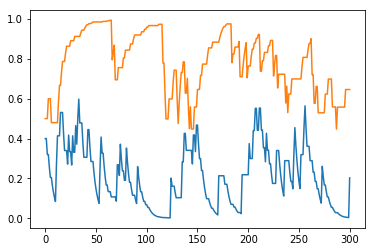

In [125]:
env=sim_env()
aG = .2
aL = .2
beta = 1
sim_rat=Rat(None,alphaG=aG,alphaL=aL,beta=beta,init_Q=np.array([0.5,0.5]))
env,sim_rat=train_rat(env,sim_rat,300)
plt.plot(sim_rat.Qlog)

In [21]:
truth = 0
for i in range(len(sim_rat.choice_Log)):
    if sim_rat.choice_Log[i] == 2:
        truth = truth + 1
truth

40

In [22]:
np.mean(sim_rat.Qlog[:,1])

0.7677194343359458

In [131]:
#MLE on simulation data
#try my minimizer
action = sim_rat.choice_Log
reward = sim_rat.obsLog
param,ll,xyz = my_minimize(action,reward)

In [132]:
from mpl_toolkits.mplot3d import Axes3D

In [136]:
param

[0.6000000000000001, 0.0, 0.5]

In [70]:
j[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

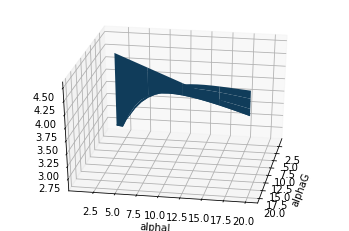

In [112]:
i=np.arange(1,21)
j=np.arange(1,21)
ll=np.array(ll)
ll=ll.reshape(20,20)
fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(j,i,ll, rstride=5, cstride=5)
plt.xlabel('alphaG')
plt.ylabel('alphaL')
ax.view_init(azim=10)

In [103]:
#try scipy optimization
result = MLE_2alpha(action,reward,0.3,0.5,4)

The optimization did not converge, beta0 equals 4 , and alphaG0 equals 0.3


In [322]:
result

      fun: 4.154861380458712
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([5.12547551e+00, 3.53503271e-01, 7.99360578e-07])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 260
      nit: 4
   status: 2
  success: False
        x: array([4.56073466e-07, 8.29522574e-01, 3.43835510e+00])

## Load Data

In [4]:
day1 = pd.read_csv('/Users/erika/Data/PRL/behavioral_data/Day 1.csvQ_Analysis.csv')
day21 = pd.read_csv('/Users/erika/Data/PRL/behavioral_data/Day 21.csvQ_Analysis.csv')

In [27]:
day1.columns

Index(['Unnamed: 0', 'subject', 'prog', 'target_lat', 'non_target_lat', 'ITI',
       'ISI', 'Tone', 'TargetOutcome', 'NonTargetOutcome', 'NAN', 'TargetSide',
       'Omission', 'TimeOut', 'SessionTime', 'NAN.1', 'NAN.2',
       'SwitchContingency', 'trial', 'position'],
      dtype='object')

In [48]:
# Let rat 30 be chosen
# low tone <==> reward
day1_30 = day1[day1['subject']==30]
day21_30 = day21[day21['subject']==30]

In [49]:
day1_30 = day1_30[['Tone','TargetOutcome','NonTargetOutcome','TargetSide']]
day21_30 = day21_30[['Tone','TargetOutcome','NonTargetOutcome','TargetSide']]

In [72]:
day1_30[:10]

,Tone,TargetOutcome,NonTargetOutcome,TargetSide
291,2000.0,1.0,0.0,1.0
292,5000.0,0.0,-1.0,1.0
293,5000.0,0.0,-1.0,1.0
294,2000.0,0.0,1.0,1.0
295,5000.0,-1.0,0.0,1.0
296,5000.0,0.0,-1.0,1.0
297,2000.0,0.0,1.0,1.0
298,5000.0,0.0,-1.0,1.0
299,5000.0,0.0,-1.0,1.0
300,5000.0,0.0,-1.0,1.0


## Get Actions and Rewards

In [73]:
1.0 ==1

True

In [74]:
#df: 4 columns of 'Tone','TargetOutcome','NonTargetOutcome','TargetSide'; df is for one rat in one session
# consisting of 1(left) and 2(right)
# suppose TargetSide=1.0 means left, 4.0 means right
def get_action(df):
    actions = []
    targetSide = df['TargetSide'].tolist()
    targetOut = df['TargetOutcome'].tolist()
    for i in range(df.shape[0]):
        act = -1
        if(targetSide[i]==1.0):
            if(targetOut[i]==0):
                act = 2
            else:
                act = 1
        else:
            if(targetOut[i]==0):
                act = 1
            else:
                act = 2
        actions.append(act)
        
    return actions
    

In [77]:
# df: 4 columns of 'Tone','TargetOutcome','NonTargetOutcome','TargetSide'; df is for one rat in one session
# reward is subjective, depending on whether the rat got reward
def get_reward(df):
    rewards = []
    targetOut = df['TargetOutcome'].tolist()
    nontargetOut = df['NonTargetOutcome'].tolist()
    
    for i in range(df.shape[0]):
        rew = -1
        if(targetOut[i] == 1 or nontargetOut[i] == 1):
            rew = 1
        else:
            rew = 0
        rewards.append(rew)
        
    return rewards

## Test

In [146]:
df = pd.read_csv('/Users/erika/Data/PRL/behavioral_data/UH_RL_rats.csv')
df.head()

,trial,TargetOffset,NonTargetOffset,ITI,ISI,Tone,TargetReward,NonTargetReward,RewardLat,Target Lever,...,response,feedback,state,action,reward,alpha_gain,alpha_loss,beta,Q,PE
0,1,31507,0,0,0,0,-1,0,0,0,...,rich,0.0,1.0,1.0,0.0,0.139603,1.0,20.0,0.000000,-0.500000
1,2,32538,0,0,0,0,1,0,0,0,...,rich,1.0,1.0,1.0,1.0,0.139603,1.0,20.0,0.139603,1.000000
2,3,0,33594,0,0,0,0,-1,0,0,...,lean,0.0,1.0,2.0,0.0,0.139603,1.0,20.0,0.000000,-0.500000
3,4,34626,0,0,0,0,1,0,0,0,...,rich,1.0,1.0,1.0,1.0,0.139603,1.0,20.0,0.259718,0.860397
4,5,0,35533,0,0,0,0,-1,0,0,...,lean,0.0,1.0,2.0,0.0,0.139603,1.0,20.0,0.000000,0.000000


In [147]:
rats = df['subject'].unique()

In [148]:
# divide df into 5 dfs according to session
# '1,11,16,6,Best'
session = df['session'].unique()
df_1 = df[df['session']=='1']
df_11 = df[df['session']=='11']
df_16 = df[df['session']=='16']
df_6 = df[df['session']=='6']
df_best = df[df['session']=='Best']
df_list = [df_1,df_11,df_16,df_6,df_best]

In [211]:
# Let rat 10 and session 'Best' be chosen
df_10_best = df_best[df_best['subject']==10]
df_10_best = df_10_best[['Tone','TargetReward','NonTargetReward','Target Lever','lever','response','feedback','state','action','reward','alpha_gain','alpha_loss','beta','PE','Q']]

In [236]:
df_19_best = df_best[df_best['subject']==19]
df_19_best = df_19_best[['Tone','TargetReward','NonTargetReward','Target Lever','lever','response','feedback','state','action','reward','alpha_gain','alpha_loss','beta','PE','Q']]

In [187]:
# Dan's parameters
df_10_best[['alpha_gain','alpha_loss','beta']].head()

,alpha_gain,alpha_loss,beta
888,0.480102,0.61508,0.355195
889,0.480102,0.61508,0.355195
890,0.480102,0.61508,0.355195
891,0.480102,0.61508,0.355195
892,0.480102,0.61508,0.355195


In [199]:
action_10_best = df_10_best['action'].tolist()
reward_10_best = df_10_best['reward'].tolist()

In [237]:
action_19_best = df_19_best['action'].tolist()
reward_19_best = df_19_best['reward'].tolist()

In [238]:
# dan's param
df_19_best[['alpha_gain','alpha_loss','beta']].head()

,alpha_gain,alpha_loss,beta
13815,0.354138,1.0,0.37386
13816,0.354138,1.0,0.37386
13817,0.354138,1.0,0.37386
13818,0.354138,1.0,0.37386
13819,0.354138,1.0,0.37386


In [263]:
# difference between likelihood
dan_ll = neg_log_likelihood_2Q_2alpha(0.3541,1.0,0.37386,action_19_best,reward_19_best)
my_ll = neg_log_likelihood_2Q_2alpha(0.4,0.95,3.5,action_19_best,reward_19_best)

In [264]:
dan_ll

3.9886884398573925

In [265]:
my_ll

3.9165242887875804

In [268]:
my_minimize(action_19_best,reward_19_best)

[0.25, 0.9500000000000001, 2.5]

In [266]:
sum(reward_19_best)

181.0

In [267]:
init_guess = [0.3,0.6,5] #alphaG,alphaL,beta
results = MLE_2alpha(action_10_best,reward_10_best,init_guess[0],init_guess[1],init_guess[2])
results

The optimization did not converge, beta0 equals 5 , and alphaG0 equals 0.3


      fun: 4.9451871395166265
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([28790647.91391581, 28790640.05848111, 28790643.51350085])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 84
      nit: 0
   status: 2
  success: False
        x: array([0.3, 0.6, 5. ])

In [207]:
neg_log_likelihood_2Q_2alpha(0.3,0.6,5,action_10_best,reward_10_best)

2.7479854198183147

## MLE, Rat 30 Day 1

In [79]:
actions_30 = get_action(day1_30)
rewards_30 = get_reward(day1_30)

In [142]:
init_guess = [0.5,0.5,3] #alphaG,alphaL,beta
results = MLE_2alpha(actions_30,rewards_30,init_guess[0],init_guess[1],init_guess[2])

The optimization did not converge, beta0 equals 3 , and alphaG0 equals 0.5


In [143]:
results

      fun: 296.43649600043045
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([58255829.69403058, 58255652.05233829, 58255779.91605542])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 84
      nit: 0
   status: 2
  success: False
        x: array([0.5, 0.5, 3. ])

## Statistical Tests

In [ ]:
# supoose we now have several rats' day1 and day 21 parameters(alphaG,alphaL,beta); paired
param_day1 = []
param_day21 = []


In [ ]:
# Q-Q plot to check normality for day 1
for i in range(len(param_day1)):
    stats.probplot(param_day1[i], dist='norm', plot=plt.plot)
    

In [ ]:
# Q-Q plot to check normality for day 21
for i in range(len(param_day21)):
    stats.probplot(param_day21[i], dist='norm', plot=plt.plot)
    

In [ ]:
# Whelch's t-test of the mean of params in day 1 versus day 21
# null hypothesis: params in day1 = day21 
t_list = []
p_list = []
for i in range(len(param_day1)):
    equal_variance = False
    t_stat, p_val = stats.ttest_ind(param_day1[i],param_day21[i], equal_var=equal_variance)
    t_list.append(t_stat)
    p_list.append(p_val)

In [30]:
#bootstrap t-test


In [ ]:
# permutation